---
# Logistic Regression with Feature Engineering and Augmented Data
---
### Summary:

To evaluate the performance of the Logistic Regression model with feature extraction when trained on augmented data. 
By augmenting MNIST sign language dataset, more noise is added to the images which simulate real-world scenario. 
Training the model on augmented data allows the model to generalise better and therefore become more robust.

### Notebook Overview:

- **Data Augmentation**:
    - Load augmented data and put into an array format for model compatibility.

- **Feature Extraction**:
    - Using HOG, LBP and Colour histogramming to create feature vectors out of images
    - To perform feature extraction with augmented data

- **Build Logistic Regression Model**:
    - Train a Logistic Regression model on the augmented data.
    - Compare the performance of the model with and without augmentation.

- **Model Evaluation**:
    - Evaluate the accuracy and performance of the Logistic Regression model.
    - Assess model coefficients to see what model has learnt when data includes augmentation

### Data Augmentation Reminder:

- rescale=1./255             
    > Normalisation of the input data is best when working with neural networks
- rotation_range=20          
    > To enusre model is able to deal with slight tilts in the hand position, most likley to occur in the real world
- width_shift_range=0.1      
    > To ensure model is able to deal with off-centered images
- height_shift_range=0.1     
    > To ensure model is able to deal with off-centered images
- shear_range=0.2            
    > To distort the image, similar to when we see objects from different perspectives
- zoom_range=0.2             
    > Zooms in and out of images so model is able to recognise signs when hands are of different sizes/furhter/closer.
- horizontal_flip=True       
    > To mimic opposite hand, if original image is left hand we can flip the image to show right hand



## Set Up
-----

In [24]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from skimage.feature import hog, local_binary_pattern
from sklearn.preprocessing import StandardScaler

import joblib

## Data Loading
----

In [25]:
X_train_aug = joblib.load( '../../data/my_data/X_train_aug.pkl')
y_train_aug = joblib.load( '../../data/my_data/y_train_aug.pkl')

In [26]:
X_val_aug = joblib.load( '../../data/my_data/X_val_aug.pkl')
y_val_aug = joblib.load( '../../data/my_data/y_val_aug.pkl')

### Getting images out of batches from keras

In [27]:
train_images = []

# Iterate over each array in X_aug
for batch in X_train_aug:
    # Iterate over each image in the batch
    for image in batch:
        image *= 255
        # Append the image to the list of all images
        train_images.append(image)

# Convert the list of images to a NumPy array
train_images_array = np.array(train_images)

In [28]:
train_class = []

# Iterate over each array in X_aug
for batch in y_train_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        train_class.append(c)

# Convert the list of images to a NumPy array
train_class_array = np.array(train_class)

In [29]:
X_train = train_images_array.reshape(-1,28,28)
y_train = train_class_array

In [30]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']
unique_values, value_counts = np.unique(y_train, return_counts=True)

## Utility Functions
----

In [31]:
def extract_features(image):
  '''
    Overview:
    Extracts HOG, LBP, and color histogram features from a 28x28 image.

    Arguments:
        - single image

    Output:
        - feature vector for a given image
  '''
  # Reshape the image if it's flattened
  image = image.reshape(28, 28)

  # Histogram of Orientated Gradients (HOG) Features
  hog_features = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))

  # LBP Features (Uniform LBP with 8 neighbors)
  lbp_features = local_binary_pattern(image, P=8, R=1, method='uniform')
  lbp_hist, bin_edges = np.histogram(lbp_features, bins=np.arange(0, lbp_features.max() + 2), density=True)

  # Color Histogram Features (8 bins per channel) -> distribution of colour (greyscale in this case)
  color_hist, bin_edges = np.histogram(image, bins=8, range=(0, 255), density=True)

  # Combining features into a single vector
  feature_vectors = np.concatenate((hog_features, lbp_hist, color_hist)) # default axis =0

  return feature_vectors


def feature_plots(input_letter):
    '''
      Overview:
        Plot to compare the original input image with the output of a given feature engineering method.

      Arguments:
        - input_letter: letter (NOT J/Z as both of these letters do not exist in dataset).
        - feature_image: The output image after feature engineering.

      Output:
        - 2 figures:
            - input image of given letter
            - image of 'new' feature
    '''

    my_image = X_train.reshape(-1,28,28)
    my_class = y_train

    if input_letter.lower() in ('j', 'z'):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        fig, axes = plt.subplots(1,3, figsize=(10, 5))

        idx1 = alphabet.index(input_letter.lower())

        feature_vector, hog_image  = hog(my_image[my_class==idx1][0], orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        lbp_features = local_binary_pattern(my_image[my_class==idx1][0], P=8, R=1, method='uniform')

        axes[0].imshow(lbp_features, cmap="gray")
        axes[0].set_title(f'Image of {input_letter.upper()} after LBP')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].imshow(my_image[my_class==idx1][0], cmap="gray")
        axes[1].set_title(f'Input Image of {input_letter.upper()}')
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        axes[2].imshow(hog_image, cmap="gray")
        axes[2].set_title(f'Image of {input_letter.upper()} after HOG')
        axes[2].set_xticks([])
        axes[2].set_yticks([])

        plt.tight_layout()
        plt.show()

def assess_coef(coef, letter_1, letter_2):
    '''
    Overview:
    Plots vector coefficients for letter_1 and letter_2 .

    Arguments:
        - coef -> Model coefficients for all letters/classes
        - letter_1 -> Letter (NOT J/Z as both of these letters do not exist in dataset)
        - letter_2 -> Letter (NOT J/Z as both of these letters do not exist in dataset)

    Output:
        - 2 figures:
            - vector coefficient for letter_1
            - vector coefficient for letter_2

    '''
    if (letter_1.lower() in ('j', 'z')) or (letter_2.lower() in ('j', 'z')):
            raise ValueError("The input letter cannot be 'j' or 'z'.")
    else:
        fig, axes = plt.subplots(2,1, figsize=(15, 5))

        # get index of letter as class is int data type
        idx_1= alphabet.index(letter_1.lower()) # having to use second alphabet list here without j and z as indicies for coef do not align with target
        idx_2= alphabet.index(letter_2.lower())

        axes[0].imshow(np.tile(coef[idx_1], (10, 1)),cmap = 'gray')
        axes[0].set_title(letter_1.upper(),fontsize='20')
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        axes[1].imshow(np.tile(coef[idx_2], (10, 1)),cmap = 'gray')
        axes[1].set_title(letter_2.upper(),fontsize='20')
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        plt.tight_layout()
        plt.show()

## Building the Logistic Regression Model
----


### Transform images to feature vectors


In [32]:
# creating feature vectors for all images in dataset
# warning as we rescaled in data augmentation and casted to float
image_feature_vectors = []
for image in X_train:
    image_feature_vectors.append(extract_features(image))
image_feature_vectors = np.array(image_feature_vectors)


In [33]:
# Sanity check on shape
image_feature_vectors.shape

(27701, 162)

In [34]:
X_train_vec = image_feature_vectors

In [35]:
X_train_vec.shape

(27701, 162)

In [36]:
my_model = LogisticRegression(solver='saga', penalty='l1', C=1, max_iter=1000)

In [37]:
my_model.fit(X_train_vec, y_train)

/Users/simybasra/anaconda3/envs/capstone_tf/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=1, max_iter=1000, penalty='l1', solver='saga')

### Vectorising X_val augmented 

In [38]:
val_images = []

# Iterate over each array in X_aug
for batch in X_val_aug:
    # Iterate over each image in the batch
    for image in batch:
        image *= 255
        # Append the image to the list of all images
        val_images.append(image)

# Convert the list of images to a NumPy array
val_images_array = np.array(val_images)

In [39]:
val_class = []

# Iterate over each array in X_aug
for batch in y_val_aug:
    # Iterate over each image in the batch
    for c in batch:
        # Append the image to the list of all images
        val_class.append(c)

# Convert the list of images to a NumPy array
val_class_array = np.array(val_class)

In [40]:
X_val= val_images_array.reshape(-1,28,28)
y_val = val_class_array

In [41]:
# creating feature vectors for all images in dataset
# warning as we rescaled in data augmentation and casted to float
val_feature_vectors = []
for image in X_val:
    val_feature_vectors.append(extract_features(image))
val_feature_vectors = np.array(val_feature_vectors)

In [42]:
X_val_vec = val_feature_vectors

In [43]:
print(f'train score: {my_model.score(X_train_vec, y_train).round(4)}')
print(f'val_score:{my_model.score(X_val_vec,y_val).round(4)}')

train score: 0.4811
val_score:0.586


**Comment:**
Performance is bad as well, again with logistic regression models data augmentation can be challenging as linear boundaries are more tricky to do when augmentation can cause a slight convergence to the centre for images of different classes. This can lead to a loss of deterministic features.

In [44]:
# saving model as pkl file
joblib.dump(my_model, '../../model/my_models/log_reg_fe_augmented_model.pkl')

['../../model/my_models/log_reg_fe_augmented_model.pkl']

## Model Evaluation
----

### Confusion Matrix

In [45]:
my_final_model = joblib.load('../../model/my_models/log_reg_fe_augmented_model.pkl')

In [46]:
pred_y = my_final_model.predict(X_val_vec)

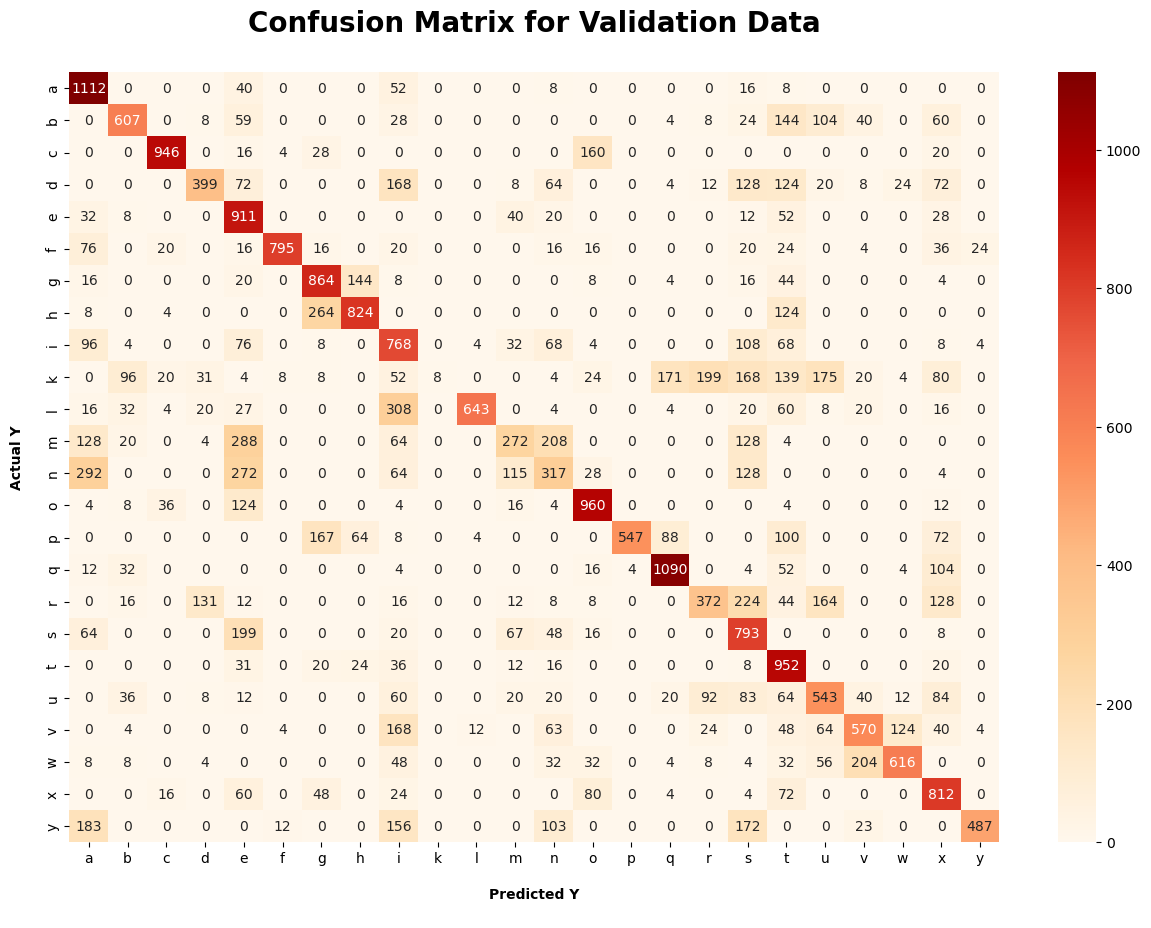

In [47]:
# Calculating the confusion matrix using sklearn.metrics
conf_matrix = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
# Using a heatmap to plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt = 'd', cmap='OrRd') # -> fmt = d casting values to int
plt.title('Confusion Matrix for Validation Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
# offsetting postion of ticks by 0.5 to move labels into the centre
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

**Comment:** 
As expected we see a higher number of misclassifications, despite using feature extraction methods performance of logistic regression model is still fairly poor.

### Assessing model coefficients

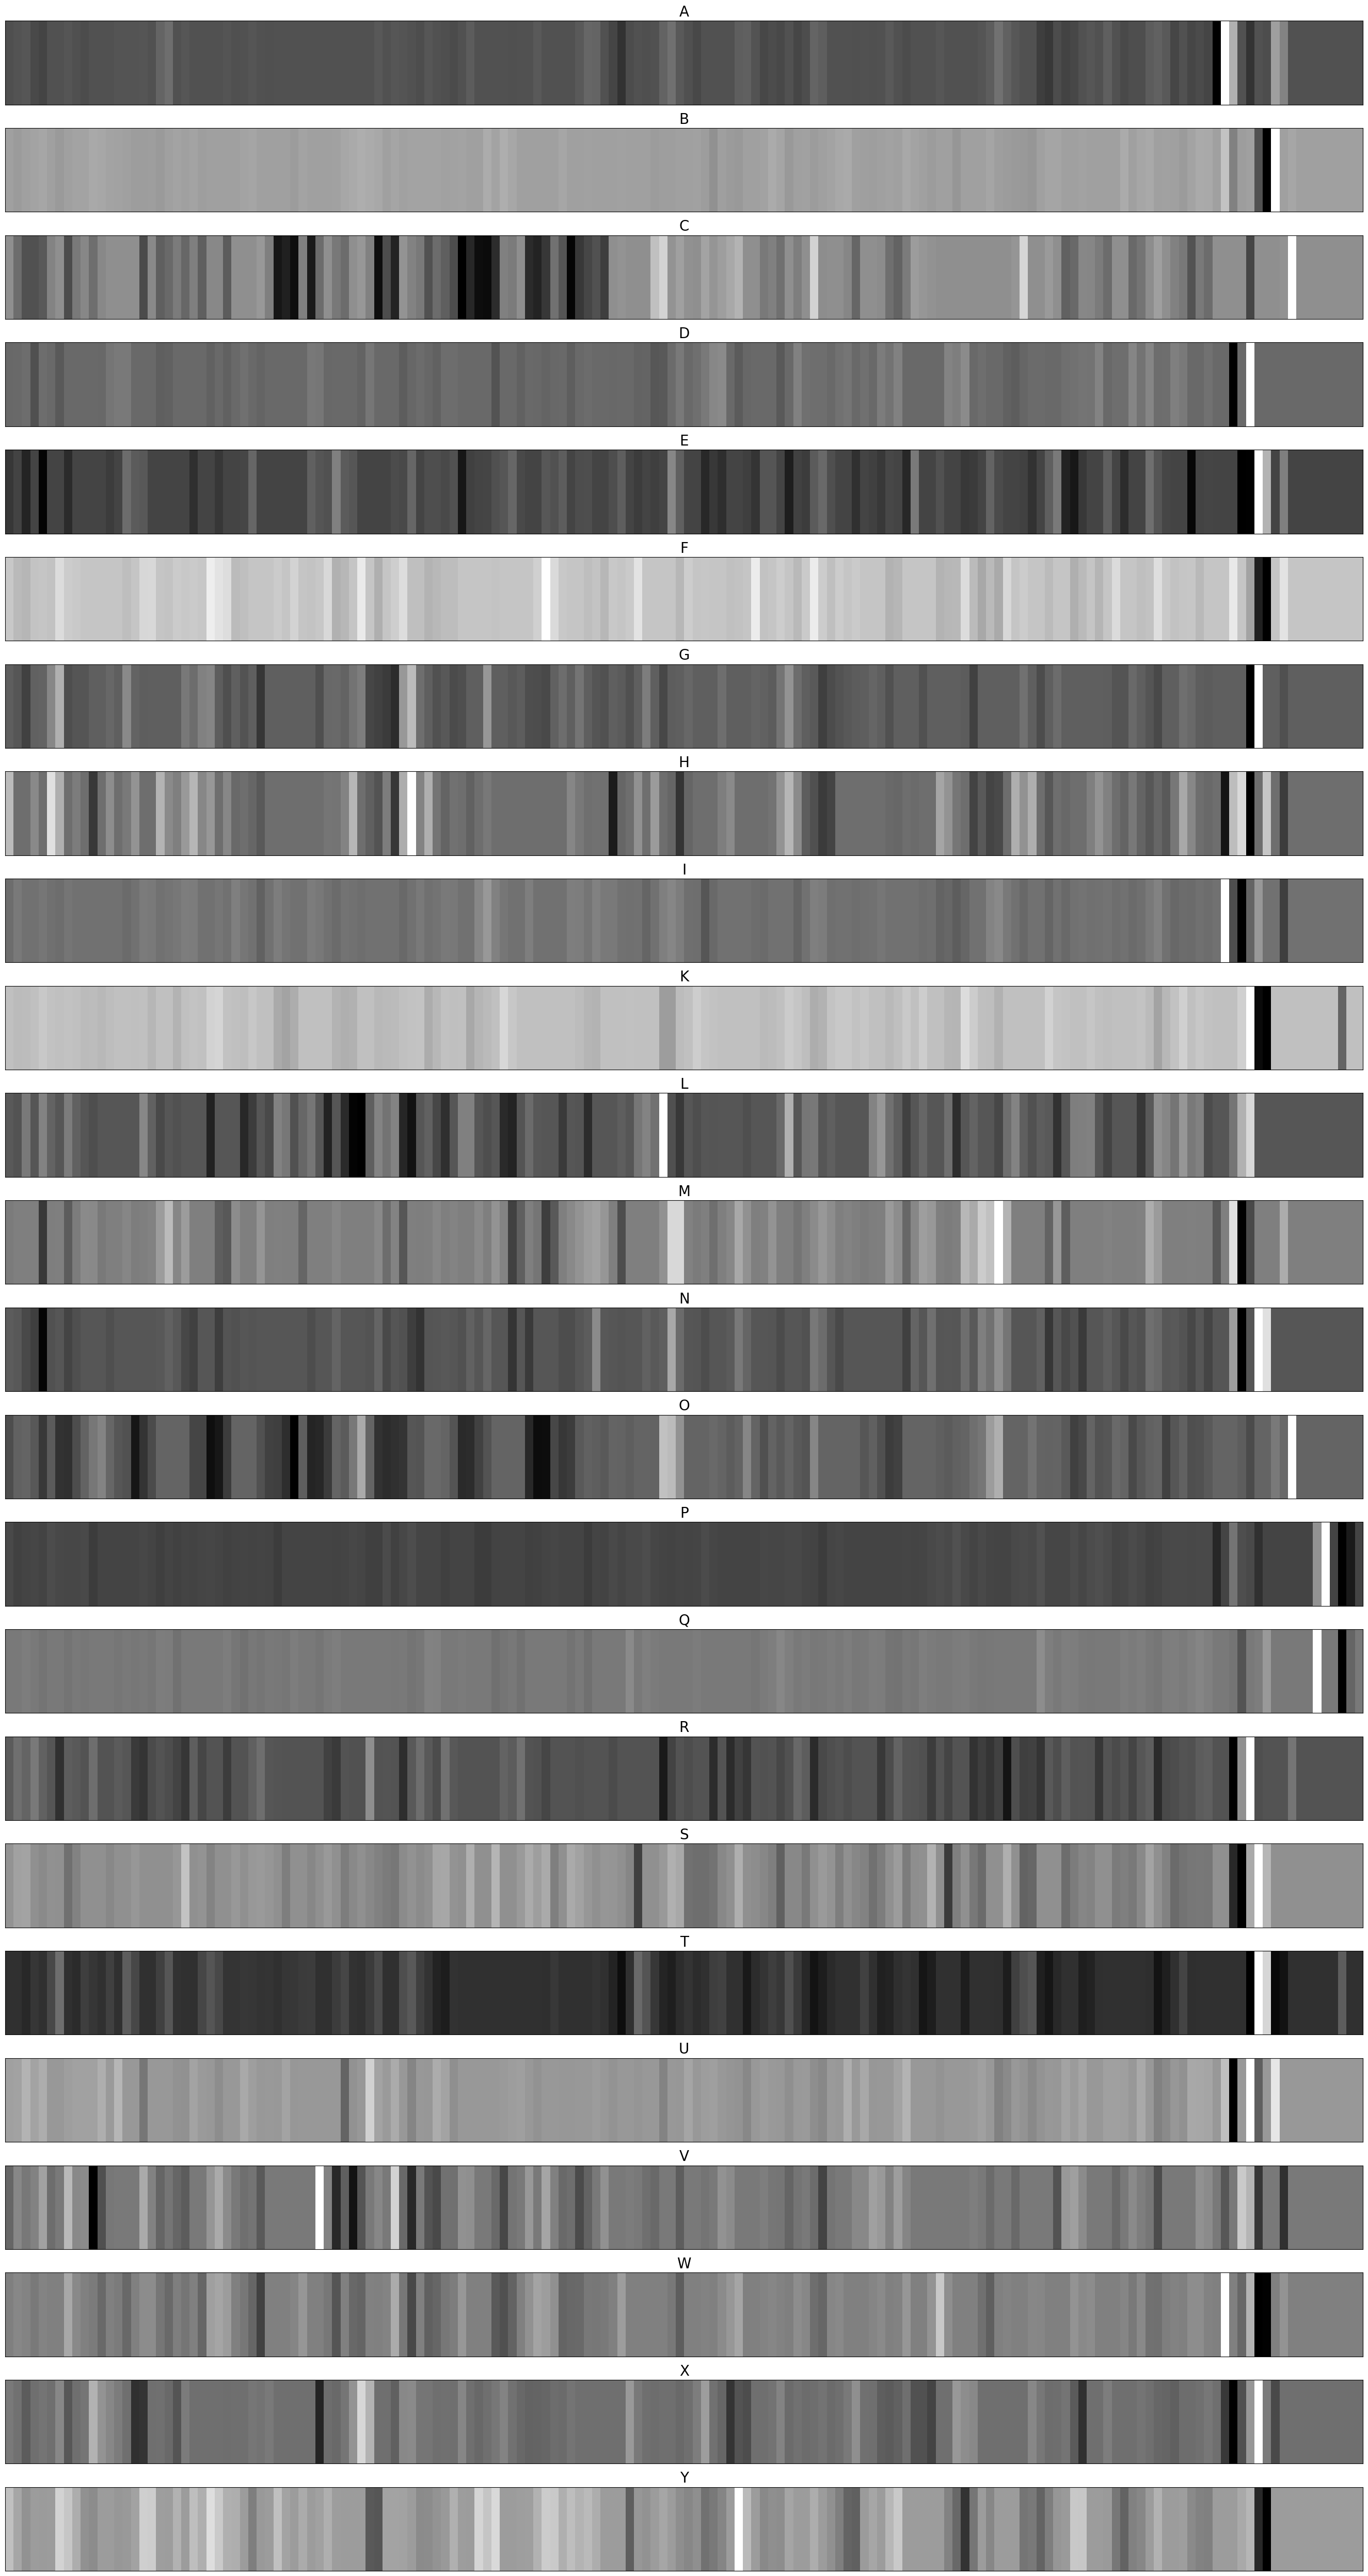

In [48]:
# Plotting of vector coefficients
letter_coef = my_final_model.coef_

fig, axes = plt.subplots(24,1, figsize=(50, 50))

for i,coef in enumerate(letter_coef):
    axes[i].imshow(np.tile(coef, (10, 1)), cmap='gray')
    axes[i].set_title(alphabet[i].upper(),fontsize='20') #-> using alphabet_jz as the i is 0 to 24
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.tight_layout()
plt.show()

**Comment:**
Now we see there is a lot of simialriteis between our vectors, this makes sense as wehn we look at the mean images the texture, edges and corners of the hands are all fairly similar and so when we perform feature extraction resulting vectors are very simialr to each other between letters.

Using the function assess_coef we will explore the similarity between the vectors further.


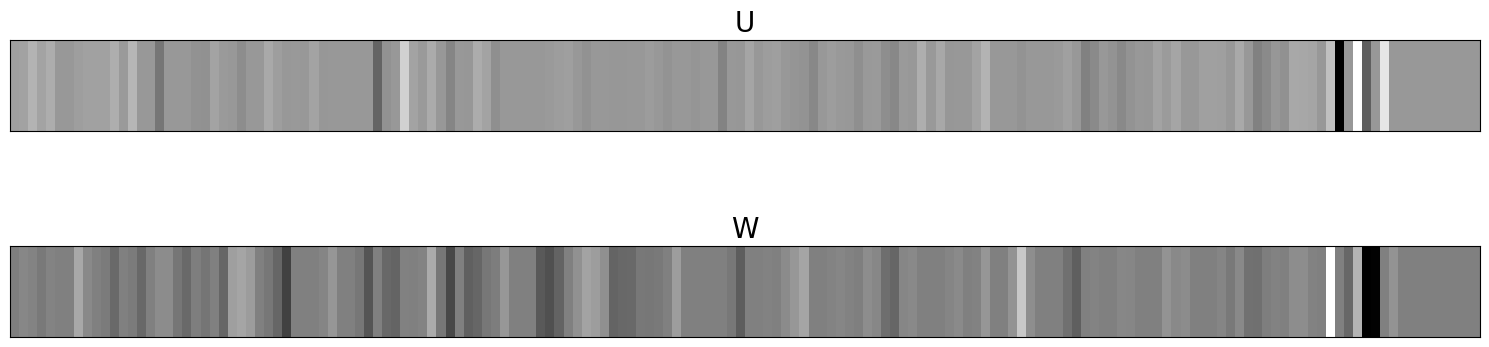

In [49]:
# Using confusion matrix identify two letters where misclassification occurs
# Assess vectors side by side to see if the coefficient vectors are similar
assess_coef(my_final_model.coef_, 'u', 'w')


**Comment:**
See there is a lot of similarity between the two feature vectors , to further investgate how simialar each of these vectors are we can look at an example of each class after HOG and LBP is applied to uncover which areas of the iamge are a across over between the two.

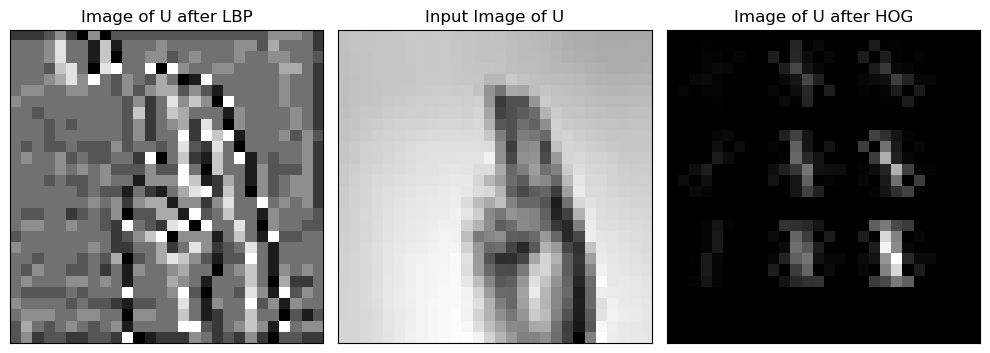

In [50]:
feature_plots('u')

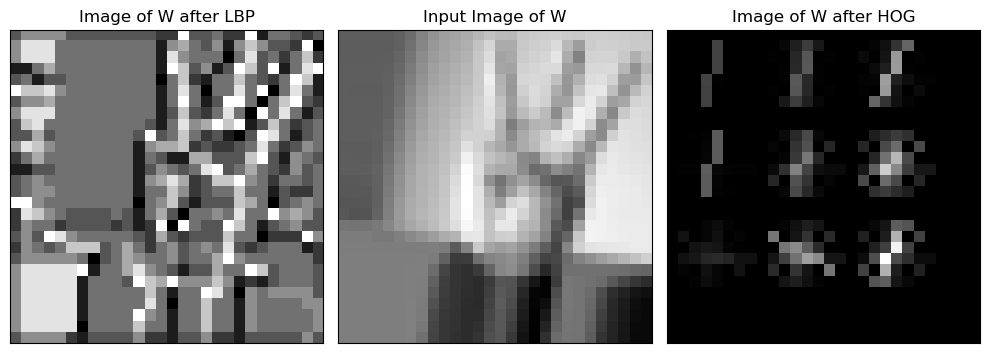

In [51]:
feature_plots('w')

**Comment:**
There are alot of simialrities especially when we look at the LBP image for both letters.

### Testing an Unseen Input Image

In [52]:
# Load model
my_final_model = joblib.load('../../model/my_models/log_reg_fe_augmented_model.pkl')

In [53]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

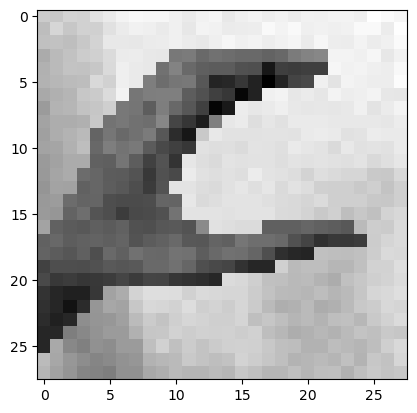

In [55]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [56]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)
# Reshape img
test_img = image_array.reshape(28,28)

In [57]:
# create feature vector out of test_img
feature_vec = extract_features(test_img)
feature_vec =feature_vec.reshape(1,-1)
feature_vec.shape

(1, 162)

In [58]:
pred = my_model.predict(feature_vec)

In [59]:
print(f'Prediction using Logistic Regression with Feature Extraction and Data Augmentation: \n{alphabet[pred[0]].upper()}')

Prediction using Logistic Regression with Feature Extraction and Data Augmentation: 
C


Surprinsingly makes the correct prediction for a 'real' image of C. This suggests feature extraction methods are more capable at handling real world images. However further tests need to be done to confirm if this is true.

## Conclusion
------

| Logistic Regression Model with Feature Extraction | Without Augmentation | With Augmentation  |
|---------------------------------------------------|----------------------|--------------------|
| Train Score                                       | 99.03                | 48.11              |
| Validation Score                                  | 98.86                | 58.60              |

The purpose of augmentation is to improve the models ability to to generalise by introducing noise and variations. However in the case of logistic regression (both with and without feature extraction), both training and validation scores are a lot lower, below are some suggested reasons as to why we are seeing these results:

- Augmentation may have been too critical for the model however I decided on my augmentation parameters in order to simulate scenarios we are most likley to see from end users.

- Perhaps we can apply some more adjsutments to the regularisation applied to our model to see if this aids performance. However I think based on the project remit its best to move to non-linear models such as neural netwokrs for this project. To ensure robustness, we need the model to capture patterns which are not typical, by this I mean patterns such as texture, edges, etc. This notebook has shown us that feature extraction alone will not achieve a suitable level of robustness.